2018 / 1 / 27

Wayne Nixalo

# RetinaNet Finetuning -- Dev

In [51]:
import keras
import keras.preprocessing.image

from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.models.resnet import custom_objects

import tensorflow as tf

import numpy as np
import os

In [52]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [53]:
istg_data_path = 'data/interstage_train/'

In [54]:
keras.backend.tensorflow_backend.set_session(get_session())

model = keras.models.load_model('data/retinanet-model/resnet50_coco_best_v1.2.2.h5',
                                    custom_objects=custom_objects)

/home/wnixalo/miniconda3/envs/aersu/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_2" during training.
  sample_weight_mode=sample_weight_mode)


In [ ]:
# model.fit_generator(data_gen, epochs=1, verbose)

In [ ]:
# model.fit_generator(data_gen, epochs=1, verbose)

So it looks like there's no native CSV-dataloader in Keras, unlike Fastai. So I'll have to write one myself. Right then, using the `.flow` method to load data, I'll write code to build arrays of the data as NumPy arrays and feed those in. **Issue**: doesn't the `.flow` method take *an* array and produce a data generator? Meaning if I want minibatches for my entire dataset, I have to have the *entire* dataset in RAM at once?

No. I'm not doing that. I think it'll work for this case, but that doesn't scale. Okay, so I think that means I have to mess with `bcolz` arrays -- they're on disk but treated like they live in memory. Fastai probably does that internally. Oof.

Is there a way to pull from multiple folders instead? Nah, it's going to treat them like different classes then no? So I have to use arrays and tell it the class.

## 1. Learning how to use bcolz again:

[Tutorial Link](https://github.com/Blosc/bcolz/blob/master/docs/tutorial_carray.ipynb)

Alright then, experimenting with loading data in as bcolz arrays.

### 1.1 Loading in a test array from directory

In [5]:
# get first folder
folder = os.listdir(istg_data_path)
folder.sort()
folder = folder[0] # make sure not `.DS_Store`

# get file list
fnames = os.listdir(istg_data_path + folder)
fnames.sort()

In [5]:
import cv2

In [7]:
data_array = []
for fname in fnames:
    data_array.append(cv2.imread(istg_data_path+folder+'/'+fname))

In [8]:
len(data_array)

413

This is the number of files in `data/interstage_train/000000-000412/` so that's good. Just a further test I got everything in my array by opening a random image:

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

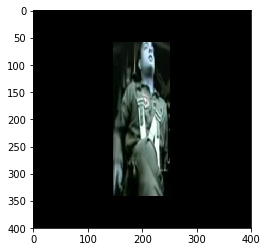

In [11]:
idx = np.random.randint(0, len(data_array))
plt.imshow(data_array[idx])

There's my image. Although I forgot that OpenCV reads them in BGR format, but that doesn't matter for this.

### 1.2 Practicing with bcolz

In [6]:
import bcolz

In [16]:
# barray = bcolz.carray(data_array, rootdir='data/tmp/')
# barray.flush()

barray = bcolz.carray(data_array, rootdir='data/tmp/', mode='w')

In [23]:
%ls data/tmp/ -all

total 20
drwxrwxr-x  4 wnixalo wnixalo 4096 Jan 27 17:40 ./
drwxr-xr-x 10 wnixalo wnixalo 4096 Jan 27 17:40 ../
-rw-rw-r--  1 wnixalo wnixalo    3 Jan 27 17:40 __attrs__
drwxrwxr-x  2 wnixalo wnixalo 4096 Jan 27 17:40 data/
drwxrwxr-x  2 wnixalo wnixalo 4096 Jan 27 17:40 meta/


In [24]:
barray.chunklen

2

In [25]:
del barray

In [27]:
barray = bcolz.open(rootdir='data/tmp/')

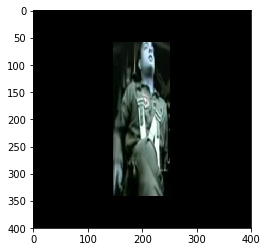

In [38]:
plt.imshow(barray[idx])

Boom. Great. Looks like I got it working. If I can enlarge this bcolz array I think I can get the `keras.preprocessing.image.ImageDataGenerator.flow(.)` method to work. The `chunklen` is 2, I guess that's not too efficient but it is good in that I can get away with any multiple of 2 batch size.

In [7]:
# get second folder
folder = os.listdir(istg_data_path)
folder.sort()
folder = folder[1] # make sure not `.DS_Store`

# get file list
fnames = os.listdir(istg_data_path + folder)
fnames.sort()

data_array = []

for fname in fnames:
    data_array.append(cv2.imread(istg_data_path+folder+'/'+fname))

In [11]:
barray = bcolz.open('data/tmp/')
len(barray)

413

So the *413th* index image should be this one, after I append the 2nd folder's images onto the first.

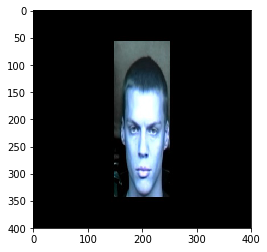

In [16]:
plt.imshow(data_array[0])

Yeah bro I feel you. 

Apparently adding data onto the bcolz carray is as simple as an `append` method?

In [17]:
barray.append(data_array)
# barray

In [20]:
%cat data/tmp/meta/storage

{"dtype": "uint8", "cparams": {"clevel": 5, "shuffle": 1, "cname": "lz4", "quantize": 0}, "chunklen": 2, "expectedlen": 413, "dflt": 0}


`"expectedlen": 413`, doesn't look like it automatically added to what's on disk. I guess I have to redefine `barray` then? Feels odd but okay.

In [21]:
barray = bcolz.carray(barray, rootdir='data/tmp', mode='w')

In [22]:
%cat data/tmp/meta/storage

{"dtype": "uint8", "cparams": {"clevel": 5, "shuffle": 1, "cname": "lz4", "quantize": 0}, "chunklen": 2, "expectedlen": 570, "dflt": 0}


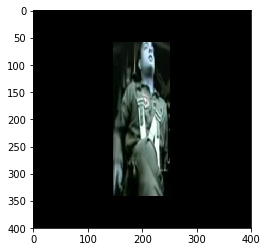

In [26]:
plt.imshow(barray[411]); # random index before was 411

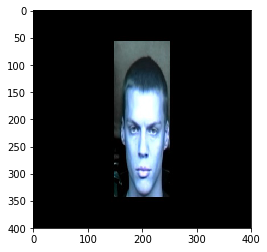

In [27]:
plt.imshow(barray[413]);

Alright well it's all there. I guess I'll write a thing to put everything into one big bcolz array and paste it below. Wow if I can even get that to train an epoch successfully tonight -- that'll be nice.

In [29]:
bcrootdir = 'data/interstage_tmp_bc'
data_array = []
bcolzarray = bcolz.carray(data_array, rootdir=bcrootdir, mode='w')

In [31]:
%cat data/interstage_tmp_bc/meta/storage

{"dtype": "float64", "cparams": {"clevel": 5, "shuffle": 1, "cname": "lz4", "quantize": 0}, "chunklen": 2048, "expectedlen": 0, "dflt": 0.0}


In [35]:
# get second folder
folder = os.listdir(istg_data_path)
folder.sort()
folder = folder[1] #

# get file list
fnames = os.listdir(istg_data_path + folder)
fnames.sort()

data_array = []

for fname in fnames:
    data_array.append(cv2.imread(istg_data_path+folder+'/'+fname))

In [33]:
bcolzarray.append(data_array)

ValueError: array trailing dimensions do not match with self

Looks like I can't initialize a bcolz carray with an empty array. What if I use the first folder's array to initialize it.

In [34]:
bcolzarray = bcolz.carray(data_array, rootdir=bcrootdir, mode='w')

In [36]:
# 2nd folder loaded as data_array
bcolzarray.append(data_array)

In [39]:
bcolzarray = bcolz.carray(bcolzarray, rootdir=bcrootdir, mode='w')

In [40]:
%cat data/interstage_tmp_bc/meta/storage

{"dtype": "uint8", "cparams": {"clevel": 5, "shuffle": 1, "cname": "lz4", "quantize": 0}, "chunklen": 2, "expectedlen": 570, "dflt": 0}


Alright. Looks like that works.

Another note, in my loop I'm saving every loop... as if to prevent an array from growing too large in memory by saving it in batches... bcolz lives on disk and appears to the Python interpreter as an in-memory array.. Meh, whatever.

### 1.3 Saving dataset as bcolz carray

In [49]:
%%time
# I can either read the master CSV or just scan the directories
path = 'data/interstage_train/'
bcrootdir = 'data/interstage_tmp_bc'

# get sorted folders
folders = os.listdir(path)
folders.sort()
if '.DS_Store' in folders:
    folders.remove('.DS_Store')

# initialize bcolz carray with first folder
fnames     = os.listdir(path+folders[0])
data_array = [cv2.imread(path+folders[0]+'/'+fname) for fname in fnames]
bcolzarray = bcolz.carray(data_array, rootdir=bcrootdir, mode='w')
folders.pop(0)

# add all files to bcolz carray
for folder in folders:
    fnames = os.listdir(path + folder)
    fnames.sort()
    data_array = [cv2.imread(path+folder+'/'+fname) for fname in fnames]
    bcolzarray.append(data_array)
    bcolzarray = bcolz.carray(bcolzarray, rootdir=bcrootdir, mode='w')

CPU times: user 1min 21s, sys: 33.5 s, total: 1min 54s
Wall time: 42.4 s


In [50]:
%cat data/interstage_tmp_bc/meta/storage

{"dtype": "uint8", "cparams": {"clevel": 5, "shuffle": 1, "cname": "lz4", "quantize": 0}, "chunklen": 4, "expectedlen": 7637, "dflt": 0}


That's indeed the full size of the data set. 7637 images. Right. Now to see if I can get a keras model to train on this.

## 2. Loading into Keras

### 2.1 Stitching CSVs together

In [ ]:
# I need to pull the bounding box labels from the interstage CSV
import pandas as pd

df = pd.read_csv('')

In [ ]:
datagen = image.ImageDataGenerator.flow()

In [55]:
path

'data/interstage_train/'

In [61]:
# WNixalo 2017-Dec-13 14:33
# NOTE: won't work right if unwanted .csv's exist in directory

import pandas as pd
# import numpy as np
from glob import glob

# list all .csv's
# g = glob('data/labels/*.csv')
g = glob('data/interstage_labels-*.csv')
# sort indices by starting image index
temp = sorted([[i,e.split('interstage_labels-')[1].split('-')[0]] for i,e in enumerate(g)], key = lambda x: int(x[1]))
# sort csv list by index
flist = [g[i[0]] for i in temp]
# initialize DataFrame as first csv
df = pd.read_csv(flist[0])
# # append all other csv's to DataFrame
for i in range(1, len(flist)):
    df = df.append(pd.read_csv(flist[i]))
# # save the new csv file
# df.to_csv('data/labels.csv', index=False)
df.to_csv('data/interstage_labels.csv', index=False)



# # NOTE: https://developers.google.com/edu/python/sorting

In [62]:
%cat data/interstage_labels.csv | head

id,gloc,x1,y1,x2,y2
000000-000412/000000,0,83,72,191,380
000000-000412/000001,0,52,89,204,381
000000-000412/000002,0,58,89,208,390
000000-000412/000003,0,66,98,214,388
000000-000412/000004,0,65,90,209,389
000000-000412/000005,0,50,73,208,386
000000-000412/000006,0,51,74,197,382
000000-000412/000007,0,49,75,200,381
000000-000412/000008,0,48,71,203,376
cat: write error: Broken pipe


In [64]:
df.head()

,id,gloc,x1,y1,x2,y2
0,000000-000412/000000,0,83,72,191,380
1,000000-000412/000001,0,52,89,204,381
2,000000-000412/000002,0,58,89,208,390
3,000000-000412/000003,0,66,98,214,388
4,000000-000412/000004,0,65,90,209,389


In [66]:
len(df)

7637

Okay I have to take a moment here and pat myself on the back. Thank you me from back in time. Wow I like that code and I had no idea what it did.. I figured that out? Nice. Lol. Anyway, I have my stitcher.

In [58]:
temp

[[3, '000000'],
 [8, '000413'],
 [4, '000570'],
 [9, '000629'],
 [6, '000640'],
 [10, '001395'],
 [16, '001883'],
 [5, '002130'],
 [1, '002439'],
 [25, '002676'],
 [15, '003317'],
 [19, '003605'],
 [0, '003906'],
 [7, '004129'],
 [13, '004152'],
 [17, '004402'],
 [23, '004599'],
 [12, '004686'],
 [20, '005023'],
 [22, '005106'],
 [24, '005452'],
 [2, '006265'],
 [21, '006409'],
 [14, '007001'],
 [18, '007090'],
 [11, '007106']]

In [59]:
flist

['data/interstage_labels-000000-000412.csv',
 'data/interstage_labels-000413-000569.csv',
 'data/interstage_labels-000570-000628.csv',
 'data/interstage_labels-000629-000639.csv',
 'data/interstage_labels-000640-001394.csv',
 'data/interstage_labels-001395-001882.csv',
 'data/interstage_labels-001883-002129.csv',
 'data/interstage_labels-002130-002438.csv',
 'data/interstage_labels-002439-002675.csv',
 'data/interstage_labels-002676-003316.csv',
 'data/interstage_labels-003317-003604.csv',
 'data/interstage_labels-003605-003905.csv',
 'data/interstage_labels-003906-004128.csv',
 'data/interstage_labels-004129-004151.csv',
 'data/interstage_labels-004152-004401.csv',
 'data/interstage_labels-004402-004598.csv',
 'data/interstage_labels-004599-004685.csv',
 'data/interstage_labels-004686-005022.csv',
 'data/interstage_labels-005023-005105.csv',
 'data/interstage_labels-005106-005451.csv',
 'data/interstage_labels-005452-006264.csv',
 'data/interstage_labels-006265-006408.csv',
 'data/int

### 2.2 Labels

In [96]:
keys = ['x1','y1','x2','y2']

In [ ]:
x1 = df['x1'].ipynb_checkpoints/

In [101]:
df.as_matrix()

array([['000000-000412/000000', 0, 83, 72, 191, 380],
       ['000000-000412/000001', 0, 52, 89, 204, 381],
       ['000000-000412/000002', 0, 58, 89, 208, 390],
       ...,
       ['007365-007636/007634', 0, 65, 69, 260, 397],
       ['007365-007636/007635', 0, 69, 68, 255, 396],
       ['007365-007636/007636', 0, 52, 53, 249, 395]], dtype=object)

In [102]:
df.as_matrix()[813]

array(['000570-001189/000813', 1, 82, 113, 215, 375], dtype=object)

Oh this is beautiful, I forgot about `.as_matrix()` before.

In [111]:
keys = dict()
for idx,key in enumerate(['x1','y1','x2','y2']):
    keys[key]=idx+2 # columsn: id, gloc, x1, y1, x2, y2    

In [110]:
[key for key in keys.keys()]

['x1', 'y1', 'x2', 'y2']

In [114]:
df_mat = df.as_matrix()
labels = [[df_mat[rdx][keys[key]] for key in keys.keys()] for rdx in range(len(df_mat))]

In [116]:
len(labels)

7637

Beautiful.

### 2.3 The Data Generator

In [120]:
datagen = keras.preprocessing.image.ImageDataGenerator.flow(bcolzarray[:], labels)

AttributeError: 'numpy.ndarray' object has no attribute 'data_format'

In [121]:
datagen = keras.preprocessing.image.ImageDataGenerator()

In [122]:
datagen.flow(bcolzarray, labels, batch_size=16)

Using 15.1G Mem, 5.20G Swap... looks like I did what I didn't want to do and loaded everything into memory.. How do I do this in batches?

Oh ***FFS***... I could load each subfolder into the data generator using `.flow_from_directory`, one at a time, and fit on them in a loop. Keras' `flow_from_directory` wants classed subdirectories... so I could set classes to `None` and use the subfolders themselves as temporary 'classes'... But Keras would see the other subdirectories and think they're different classes... so I'd have to change the directory structure to hide that from it.. Good God.. 

That would handle the memory issue but require directory changes which I don't want to do.

Instead I could do a loop, but instead with `.flow` and smaller bcolz arrays, split by subfolder. I'd still have the entire folder in RAM, but it wouldn't be the entire dataset.

Is this really the way it has to be done w/ Keras? I don't remember the 2017 version of Fastai DL1 using anything other than `.flow_from_directory` but I'll have to check their `utils` file.

In [124]:
datagen.data_format

'channels_last'

In [135]:
datagen.fit(bcolzarray)

MemoryError: 

In [128]:
len(bcolzarray)

7637

In [130]:
batch_size=16

In [133]:
model.fit_generator(datagen, steps_per_epoch=len(bcolzarray)//batch_size, epochs=1, verbose=1)

Epoch 1/1


TypeError: 'ImageDataGenerator' object is not an iterator

Okay. I'm coming back to this tomorrow.

22:25 2018/1/27

WNixalo